# Imports

In [76]:
import re
import json
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial
from scipy.sparse import hstack
from multiprocessing import Pool as mp
from catboost import CatBoostClassifier, Pool
from preprocessing import parse_text, data_preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

# Input data

Загрузим исходные данные для обучения

In [2]:
input_data = pd.read_csv("./test.csv")

print(input_data.shape)
display(input_data.head())

(432158, 3)


,title,text,topic
0,Британцы отмечают двухлетие смерти Дианы,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
1,Еще одно землетрясение в Турции: один человек ...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
2,Российские национал-большевики убирают террито...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
3,Киргизия ведет бои на границах с Таджикистаном...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
4,Литва засудила участников переворота 91 года,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир


Посмотрим на распределение целевой переменной `target`

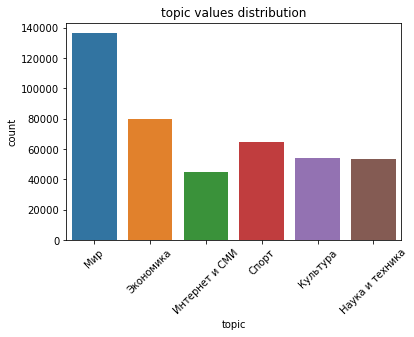

In [3]:
ax = sns.countplot(data=input_data, x="topic")
ax.set_title(label="topic values distribution")
ax.tick_params(axis='x', labelrotation=45);

В данных присутствует некоторый дисбаланс классов. Количество новостей по теме `Мир` приблизительно в два раза больше количества каждой из остальных тем. С моей точки зрения, дисбаланс классов не столь критичен и решается регуляризацией и использованием весовых коэффициентов в расчете функции потерь в соответствии с размером класса.

Проверим, что в колонке `text` во всех элементах присутствует тэг `<person></person>`, который сожержит в себе какую-либо информацию.

In [4]:
pattern = re.compile(r"(?<=<person>)([\s\S]*)(?=</person>)")
assert (~input_data["text"].str.contains(pat=pattern)).sum() == 0, "Some elements do not have tag <person></person>"

Отлично. Извлечем необходимую информацию из колонки `text` с помощью `BeautifulSoup`

In [5]:
# with mp(processes=4) as pool:
#     input_data = input_data.assign(text_parsed=pool.map(partial(parse_text, tag="person"), input_data["text"].values))

Или с помощью регулярных выражений (работает быстрее)

In [6]:
input_data["text_parsed"] = input_data["text"].str.extract(pat=pattern).loc[:, 0]

Посмотрим, как распределено количество символов в колонках `text` и `title`

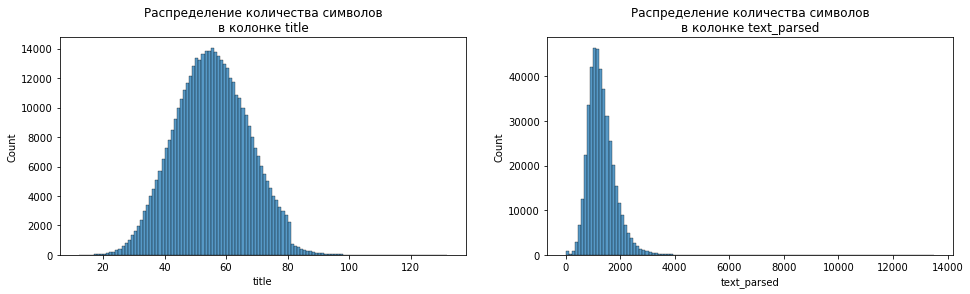

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.histplot(input_data["title"].str.len(), ax=ax[0], bins=120)
ax[0].set_title(label="Распределение количества символов\nв колонке title")
sns.histplot(input_data["text_parsed"].str.len(), ax=ax[1], bins=120)
ax[1].set_title(label="Распределение количества символов\nв колонке text_parsed")
fig.show();

Как мы видим, есть последовательности в колонке `text_parsed`, длина которых равна 0. Выведем эти объекты.

In [9]:
for i, row in input_data[input_data["text_parsed"].str.len() == 0].iterrows():
    print(f"Row index: [{i}]")
    print("\tЗаголовок:")
    print("\t" + row["title"])
    print("\tТекст:")
    print("\t" + row["text"])

Row index: [91190]
	Заголовок:
	В Стамбуле горит багажное отделение аэропорта "Ататюрк"
	Текст:
	<?xml version="1.0" encoding="utf-8"?>
<conversion><person></person></conversion>
Row index: [353942]
	Заголовок:
	Гребенщиков заработал 10 тысяч рублей в омском подземном переходе
	Текст:
	<?xml version="1.0" encoding="utf-8"?>
<conversion><person></person></conversion>


Как мы видим, в некоторых текстах присутствует только символ новой строки. Такой текст не несет абсолютно никакой информации, но может быть достаточно заголовка для определения тематики текста, поэтому удалять такие объекты не будем. Также есть объекты нашей выборки, длина текста в колонке `text_parsed` которых не равна 0, но очень мала. Выведем некоторые из них:

In [10]:
for i, row in input_data[input_data["text_parsed"].str.len() < 10].iloc[:5].iterrows():
    print(f"Row index: [{i}]")
    print("\tЗаголовок:")
    print("\t" + row["title"])
    print("\tТекст:")
    print("\t" + row["text"])

Row index: [26133]
	Заголовок:
	Американские конгрессмены пытаются ускорить принятие закона о запрете копирования
	Текст:
	<?xml version="1.0" encoding="utf-8"?>
<conversion><person>Wired</person></conversion>
Row index: [47930]
	Заголовок:
	Новый франко-японский "Конкорд" будет летать в два раза быстрее
	Текст:
	<?xml version="1.0" encoding="utf-8"?>
<conversion><person>EADS</person></conversion>
Row index: [54004]
	Заголовок:
	На украинских артиллерийских складах огонь подобрался к ракетам
	Текст:
	<?xml version="1.0" encoding="utf-8"?>
<conversion><person>ИТАР-ТАСС</person></conversion>
Row index: [54082]
	Заголовок:
	Джордж Буш отправился в Пентагон спасать Рамсфелда от отставки
	Текст:
	<?xml version="1.0" encoding="utf-8"?>
<conversion><person>Пентагон</person></conversion>
Row index: [54096]
	Заголовок:
	Прототип европейского челнока уронили с высоты 2,4 километра
	Текст:
	<?xml version="1.0" encoding="utf-8"?>
<conversion><person>MSNBC</person></conversion>


В некоторых случаях это названия компаний, источника новостей.

Взглянем, есть ли в наших данных пропущенные значения.

In [11]:
input_data.isna().sum(axis=0)

title          0
text           0
topic          0
text_parsed    0
dtype: int64

# TF-IDF

Напомним, что такое TF-IDF. Рассчитывается для каждого слова $t$ в документе $d$.

$$
\text{TF-IDF} \left( t, d, D \right) = \text{TF} \left( t, d \right) \cdot \text{IDF} \left( t, D \right)
$$

где,

$\text{TF} \left( t, d \right)$ - _term frequency_. Показывает то, как часто встречается слово $t$ в документе $d$:

$$
\text{TF} \left( t, d \right) = \frac{\text{количество повторений слова $t$ в документе $d$}}{\text{количество слов в документе $d$}}
$$

$\text{IDF} \left( t, D \right)$ - _inverted document frequency_. Отражает то, в каком количестве документов из корпуса всех документов $D$ встречается слово $t$:

$$
\text{IDF} \left( t, D \right) = \log \frac{\text{общее количество документов}}{\text{количество документов, в которых встречается слово $t$}}
$$

При этом, если слово встречается в каждом документе корпуса текстов, то $\text{IDF} = 0 => \text{TF-IDF} = 0$. И это верно, т.к. данное слово не характеризует конкретный документ.

## Input data preprocessing

В данном разделе предобработаем наши данные для дальнейшего обучения моделей. Для предподготовки данных используем библиотеку `spacy`.

In [8]:
ru_nlp = spacy.load("ru_core_news_lg")

Для классификации текста по темам с помощью простых моделей `BoW`, `TF-IDF` и т.д. с классификатором на деревьях нет необходимости во всех частях речи. Поэтому во время предобработки данных оставим только ключевые.

Таблица с частями речи `spacy` (POS - part of speech)

| POS | DESCRIPTION | описание | EXAMPLES |
| --- | --- | --- | --- |
| ADJ | adjective | прилагательное | *big, old, green, incomprehensible, first* |
| ADP | adposition | предлог | *in, to, during* |
| ADV | adverb | наречие | *very, tomorrow, down, where, there* |
| AUX | auxiliary |  | *is, has (done), will (do), should (do)* |
| CONJ | conjunction |  | *and, or, but* |
| CCONJ | coordinating conjunction |  | *and, or, but* |
| DET | determiner |  | *a, an, the* |
| INTJ | interjection |  | *psst, ouch, bravo, hello* |
| NOUN | noun |  | *girl, cat, tree, air, beauty* |
| NUM | numeral |  | *1, 2017, one, seventy-seven, IV, MMXIV* |
| PART | particle |  | *’s, not,* |
| PRON | pronoun |  | *I, you, he, she, myself, themselves, somebody* |
| PROPN | proper noun |  | *Mary, John, London, NATO, HBO* |
| PUNCT | punctuation |  | *., (, ), ?* |
| SCONJ | subordinating conjunction |  | *if, while, that* |
| SYM | symbol |  | *\$, %, §, ©, +, −, ×, ÷, =, :), 😝* |
| VERB | verb |  | *run, runs, running, eat, ate, eating* |
| X | other |  | *sfpksdpsxmsa* |
| SPACE | space |  |  |

В первом приближении для нас актуальны следующие части речи (некоторые из POS в корпусе русских текстов не присутствуют впринципе):
- ADJ
- NOUN
- PROPN
- VERB

### Target encoding

Во первых, необходимо закодировать целевую переменную. Сделаем это с помощью `LabelEncoder` из `sklearn`.

In [9]:
le = LabelEncoder()
input_data["topic_encoded"] = le.fit_transform(input_data["topic"])

Выведем закодированные классы

In [52]:
dict(zip(range(len(le.classes_)), le.classes_))

{0: 'Интернет и СМИ',
 1: 'Культура',
 2: 'Мир',
 3: 'Наука и техника',
 4: 'Спорт',
 5: 'Экономика'}

### Title and text preprocessing

Для токенизации и лемматизации слов используем стандартные инструменты `spacy`.

In [10]:
data_preprocessing(
    input_data["title"].to_list(), input_data["text_parsed"].to_list(), nlp=ru_nlp, 
    pos=["ADJ", "NOUN", "PROPN", "VERB"], n_process=4, filename="./tf_idf_preprocessed_data.txt")

## Read preprocessed data from file

In [10]:
with open("./tf_idf_preprocessed_data.txt", "r", encoding="utf-8") as f:
    titles = json.loads(f.readline())
    texts  = json.loads(f.readline())
    
print(f"Size of titles:\t\t{len(titles)}")
print(f"Size of texts:\t\t{len(texts)}")
print(f"Size of input data:\t{input_data.shape[0]}")

Size of titles:		432158
Size of texts:		432158
Size of input data:	432158


## Train / Val / Test split

При использовании бустинга, мы разбиваем нашу выборку на три подвыборки: тренировочная, валидационная и тестовая. Валидационная выборка необходима для контроля обучения и в случае, если значение функции потерь на валидационной выборке начинает расти, то мы останавливаем процесс обучения. Таким образом, мы препятствуем переобучению модели.

На тестовой выборке производится оценка качества нашей модели.

Заголовки и тексты векторизуем по отдельности, а затем объединим их матрицы признаков. Итоговую матрицу будем использовать для обучения моделей.

In [11]:
x_train_title, x_rest_title, x_train_text, x_rest_text, y_train, y_rest = \
    train_test_split(titles, texts, input_data["topic_encoded"].values, train_size=0.8, shuffle=True, 
                     stratify=input_data["topic_encoded"].values, random_state=42)
x_eval_title, x_test_title, x_eval_text, x_test_text, y_eval, y_test = \
    train_test_split(x_rest_title, x_rest_text, y_rest, train_size=0.5, shuffle=False)

print(f"Train:\n" \
      f"\tx_train_title:\t{len(x_train_title)}\n\tx_train_text:\t{len(x_train_text)}\n\ty_train:\t{y_train.shape[0]}\n" \
      f"Eval:\n" \
      f"\tx_eval_title:\t{len(x_eval_title)}\n\tx_eval_text:\t{len(x_eval_text)}\n\ty_eval:\t\t{y_eval.shape[0]}\n" \
      f"Test:\n" \
      f"\tx_test_title:\t{len(x_test_title)}\n\tx_test_text:\t{len(x_test_text)}\n\ty_test:\t\t{y_test.shape[0]}")

Train:
	x_train_title:	345726
	x_train_text:	345726
	y_train:	345726
Eval:
	x_eval_title:	43216
	x_eval_text:	43216
	y_eval:		43216
Test:
	x_test_title:	43216
	x_test_text:	43216
	y_test:		43216


## TF-IDF + CatBoost Classifier

### TF-IDF vectorization

Векторизуем тексты. Т.к. тексты у нас довольно-таки большие, то ограничим количество слов в итоговом `vocabulary`. Сделаем это следующим образом:
- с помощью параметра `max_df` выбросим все слова, для которых $\text{DF} > 0.9$ (т.е. _document frequency_ - относительное количество документов в которых встречается слово $t$ от общего числа документов в корпусе).
- с помощью параметра `min_df` выбросим все слова, для которых абсолютное количество документов, в которых встречается слово $t$, меньше 5
- также были выброшены токены, которые сожержали еще символы кроме русских букв и были короче 4-х символов (см. `pattern`).

Отдельно векторизуем заголовки, и отдельно тексты. Затем полученные матрицы объединим в одну.

In [26]:
def dummy_fun(doc):
    return doc


def tokenizer(sequence: list, pattern: re.Pattern = None) -> list:
    if not pattern:
        return sequence
    return list(filter(pattern.fullmatch, sequence))


def build_tokenzier(tokenizer, pattern: re.Pattern = None):
    return partial(tokenizer, pattern=pattern)


# fit tfidf on titles and texts
pattern = re.compile(r"[а-яё]{4,}", flags=re.IGNORECASE)
tfidf_title = TfidfVectorizer(
    analyzer='word', tokenizer=build_tokenzier(tokenizer, pattern), preprocessor=dummy_fun, max_df=0.9, min_df=10)
tfidf_text = TfidfVectorizer(
    analyzer='word', tokenizer=build_tokenzier(tokenizer, pattern), preprocessor=dummy_fun, max_df=0.9, min_df=10)

x_train_features_title, x_train_features_text = \
    tfidf_title.fit_transform(x_train_title), tfidf_text.fit_transform(x_train_text)
x_eval_features_title, x_eval_features_text = \
    tfidf_title.transform(x_eval_title), tfidf_text.transform(x_eval_text)
x_test_features_title, x_test_features_text = \
    tfidf_title.transform(x_test_title), tfidf_text.transform(x_test_text)

# print out the vocabulary sizes
print(f"Title vocabulary size:\t{len(tfidf_title.get_feature_names())}")
print(f"Text vocabulary size:\t{len(tfidf_text.get_feature_names())}")

Title vocabulary size:	13354
Text vocabulary size:	57530


Объединим вектора заголовков и текстов

In [27]:
x_train_features = hstack((x_train_features_title, x_train_features_text))
x_eval_features = hstack((x_eval_features_title, x_eval_features_text))
x_test_features = hstack((x_test_features_title, x_test_features_text))

### Train the model

In [28]:
train_pool, eval_pool = Pool(data=x_train_features, label=y_train), Pool(data=x_eval_features, label=y_eval)

In [29]:
catboost_cls = CatBoostClassifier(iterations=3000, learning_rate=0.3, max_depth=2, eval_metric='MultiClass',
                                  l2_leaf_reg=None, custom_loss=["Accuracy", "Precision", "Recall"], random_state=42)
catboost_cls.fit(train_pool, eval_set=eval_pool, plot=True, verbose=100, early_stopping_rounds=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5729650	test: 1.5714904	best: 1.5714904 (0)	total: 7.75s	remaining: 6h 27m 33s
100:	learn: 0.5133892	test: 0.5195796	best: 0.5195796 (100)	total: 6m 25s	remaining: 3h 4m 14s
200:	learn: 0.4023350	test: 0.4112372	best: 0.4112372 (200)	total: 12m 48s	remaining: 2h 58m 24s
300:	learn: 0.3529547	test: 0.3629055	best: 0.3629055 (300)	total: 18m 58s	remaining: 2h 50m 13s
400:	learn: 0.3253888	test: 0.3363863	best: 0.3363863 (400)	total: 25m 8s	remaining: 2h 42m 57s
500:	learn: 0.3100867	test: 0.3219137	best: 0.3219137 (500)	total: 31m 7s	remaining: 2h 35m 16s
600:	learn: 0.2998001	test: 0.3126066	best: 0.3126037 (598)	total: 37m 9s	remaining: 2h 28m 19s
700:	learn: 0.2938525	test: 0.3072340	best: 0.3072340 (700)	total: 43m	remaining: 2h 21m 3s
800:	learn: 0.2893298	test: 0.3033638	best: 0.3033637 (799)	total: 48m 53s	remaining: 2h 14m 12s
900:	learn: 0.2847782	test: 0.2996170	best: 0.2996170 (900)	total: 54m 56s	remaining: 2h 8m
1000:	learn: 0.2817939	test: 0.2972628	best: 0.2972

### Evaluation

Рассчитаем метрики качества классификации

In [88]:
def evaluate(classificator, x: np.array, y_true: np.array, label: str = "train") -> None:
    y_hat_proba = classificator.predict_proba(x)
    
    # ROC-AUC
    # OVO - one vs one
    # OVR - one vs rest
    
    print(f"Classification report on {label} set:\n")
    print(f"ROC-AUC score")
    print("\tOVO: {:.2f}".format(roc_auc_score(y_true=y_true, y_score=y_hat_proba, multi_class="ovo")))
    print("\tOVR: {:.2f}".format(roc_auc_score(y_true=y_true, y_score=y_hat_proba, multi_class="ovr")))
    print()
    print(classification_report(y_true=y_true, y_pred=y_hat_proba.argmax(axis=1)))
    return

evaluate(classificator=catboost_cls, x=x_train_features, y_true=y_train)
evaluate(classificator=catboost_cls, x=x_eval_features, y_true=y_eval, label="eval")
evaluate(classificator=catboost_cls, x=x_test_features, y_true=y_test, label="test")

Classification report on train set:

ROC-AUC score
	OVO: 0.99
	OVR: 0.99

              precision    recall  f1-score   support

           0       0.86      0.80      0.83     35730
           1       0.93      0.92      0.93     43038
           2       0.91      0.94      0.92    109297
           3       0.90      0.87      0.88     42509
           4       0.98      0.97      0.98     51530
           5       0.92      0.93      0.93     63622

    accuracy                           0.92    345726
   macro avg       0.92      0.91      0.91    345726
weighted avg       0.92      0.92      0.92    345726

Classification report on eval set:

ROC-AUC score
	OVO: 0.99
	OVR: 0.99

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      4448
           1       0.92      0.92      0.92      5354
           2       0.90      0.93      0.92     13610
           3       0.90      0.86      0.88      5408
           4       0.98      0.97      